## Trabalho 1 - IA 
### k-Nearest Neighbours 
### Integrantes
- Breno da Silva Nogueira
- Caio Vinicius Melo
- Juliana Almeida Santos

## Informações importantes sobre o dataset
Todos os atributos: 
- A1:	b, a.
- A2:	Atributo Contínuo.
- A3:	Atributo Contínuo.
- A4:	u, y, l, t.
- A5:	g, p, gg.
- A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7:	v, h, bb, j, n, z, dd, ff, o.
- A8:	Atributo Contínuo.
- A9:	t, f.
- A10: t, f.
- A11: Atributo Contínuo.
- A12: t, f.
- A13: g, p, s.
- A14: Atributo Contínuo.
- A15: Atributo Contínuo.
- A16: +,-  (Atributo para classificar) 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Importando o dataset
df = pd.read_csv("crx.csv")
df.head()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Sabemos que há valores faltantes nos seguintes atributos (informação fornecida na descrição do dataset):

- A1:  12
- A2:  12
- A4:   6
- A5:   6
- A6:   9
- A7:   9
- A14: 13

In [ ]:
# Utilizando a moda de cada um dos valores não-numericos, vamos preencher os valores faltantes
def fill_na_cat(df, cols):
    # Itera por toda as colunas não-numéricas passadas
    for col in cols:
        # Retorna a valor com maior incidência
        moda = df[col].value_counts().sort_values(ascending=False).index[0]

        # Substitui os valores NA pela moda
        df.loc[df[col] == "?", col] = moda

# Retirando todos os ("?") das colunas categóricas
fill_na_cat(df, ["a1", "a4", "a5", "a6", "a7"])

In [3]:
# Utilizando a mediana de cada um dos valores numéricos, vamos preencher os valores faltantes
def fill_na_num(df, cols):
    for col in cols:
        # Substitui o NA ("?") por um valor indexável pelo sklearn, para que possa ser feito o calculo da mediana
        df.loc[df[col] == "?", col] = np.NaN

# Retirando todos os ("?") das colunas numéricas
fill_na_num(df, ['a2', 'a14'])
df.head(3)

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,f,g,00280,824,+


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Separando os preditores e o alvo de predição
X = df.drop("a16", axis=1)
y = df['a16'].copy()


# Pegando as colunas numéricas e categóricas
num_cols = ['a2', 'a3', 'a8', 'a14','a15']
cat_cols = [att for att in X.columns.tolist() if att not in num_cols]

# Pipeline de preparação de dados
num_pipeline = Pipeline([
    # Substitui todos os valores NA pela mediana
    ('imputer', SimpleImputer(missing_values=np.NaN, strategy="median")),
    # Faz a normalização de todos os valores
    ('std_scaler', StandardScaler())
])

# Aplica a pipeline
df_num = X[num_cols]
num_pipeline.fit_transform(df_num)

# Agregador das colunas transformadas
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    # Faz a codificação de OneHot 
    ("cat", OneHotEncoder(sparse_output=False), cat_cols)
])

# Aplica a codificação
X = full_pipeline.fit_transform(X)

In [5]:
# Faz a divisão entre conjunto de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Faz a tradução das classes para valores numéricos
def prepare_labels(df):
    df.loc[df == "+"] = 1
    df.loc[df == "-"] = 0

# Prepara as classes de treino e teste
prepare_labels(y_train)
prepare_labels(y_test)

# Transforma todos os valores em valores inteiro para evitar erros no modelo
y_train = y_train.astype('int').to_numpy()
y_test = y_test.astype('int').to_numpy()

In [7]:
from collections import Counter

# Classe do KNN seguindo o modelo de implementação do skLearn (fit, transform, predict)
class KNearestNeighbours:
    def __init__(self, k_neighbours=3):
        self.k_neighbours = k_neighbours

    # Método para treinar o modelo
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Método intermediário para retornar as predições
    def predict(self, X):
        pred = []
        for x in X:
            pred.append(self.predictor(x))

        return pred

    # Método para retornar a distância euclidiana
    def euclidian_dist(self, x, y):
        return np.sqrt(np.sum((x - y)**2))

    # Método para predizer a classe de um elemento
    def predictor(self, x):
        # Calcular as distâncias euclidianas do ponto que queremos classificar
        dist = []
        for x_train in self.X_train:
            dist.append(self.euclidian_dist(x, x_train))
    
        # Retornar os índices dos k-mais-próximos ordenando as distâncias e retornando os indices
        k_index = np.argsort(dist)[:self.k_neighbours]

        # Retorna qual a classe que os índices pertencem
        k_labels = [self.y_train[i] for i in k_index]

        # Dentro das classes, retorna o que mais ocorre
        most_common = Counter(k_labels).most_common()[0][0]
        return most_common

In [8]:
# Cria uma instância do modelo e treina com os valores tratados
knn_us = KNearestNeighbours(k_neighbours=3)
knn_us.fit(X_train, y_train)

# Faz as predições
predictions_us = np.asarray(knn_us.predict(X_test))
predictions_us

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1])

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Usar o mesmo modelo com uma biblioteca pronta (sklearn), para efeito de comparação
knn_sk  = KNeighborsClassifier(n_neighbors=3)
knn_sk.fit(X_train, y_train)
predictions_sk = knn_sk.predict(X_test)

In [10]:
# Classe pra agregar todas as métricas a serem usadas
class Metrics:
    # Calcula a taxa de acerto de dois resultados
    def hit_rate(self, x, y):
        som = 0
        for i, j in zip(x, y):
            if i == j:
                som += 1

        return som / len(y)
    
    # Constroi uma matriz de confusão binária
    def confusion_matrix(self, x, pred, out="confusion"):
        TP, FP, TN, FN = 0, 0, 0, 0
        for i, j in zip(x, pred):
            if i == j:
                if i == 0:
                    TN += 1
                else:
                    TP += 1
            else:
                if i == 0:
                    FP += 1
                else:
                    FN += 1

        if out == "confusion":
            return [[TN, FN], [FP, TP]]
        elif out == "accuracy":
            return (TP, TN, FP, FN)

    # Cálculo da Acurácia
    def accuracy(self, x, pred):
        TP, TN, FP, FN = self.confusion_matrix(x, pred, out="accuracy")
        return (TP + TN) / (TP + TN + FP + FN)

    # Cálculo da Taxa de Erro
    def error_rate(self, x, pred):
        return 1 - self.accuracy(x, pred)
    
    # Cálculo da Precisão
    def precision(self, x, pred):
        TP, _, FP, _ = self.confusion_matrix(x, pred, out="accuracy")
        return TP / (TP + FP)
    
    # Cálculo da Revocação
    def recall(self, x, pred):
        TP, _, _, FN = self.confusion_matrix(x, pred, out="accuracy")
        return TP / (TP + FN)
    
    def TPR(self, x, pred):
        return self.recall(x, pred)
    
    def FPR(self, x, pred):
        _, TN, FP, _ = self.confusion_matrix(x, pred, out="accuracy")
        return FP / (TN + FP)
    
    # Cálculo da F1-Score (ou F-Measure)
    def f1_score(self, x, pred):
        re = self.recall(x, pred)
        pr = self.precision(x, pred)
        return (2 * pr * re) / (pr + re)
    
    # Utilidade para mostrar as principais métricas
    def full_metrics(self, x, pred):
        printer = self.hit_rate(x, pred) * 100
        print("Taxa de Acerto:", f"{printer:.2f}%")
        printer = self.error_rate(x, pred) * 100
        print("Taxa de Erro: ", f"{printer:.2f}%")
        printer = self.accuracy(x, pred) * 100
        print("Acurácia: ", f"{printer:.2f}%")
        printer = self.precision(x, pred) * 100
        print("Precisão: ", f"{printer:.2f}%")
        printer = self.recall(x, pred) * 100
        print("Revocação: ", f"{printer:.2f}%")
        printer = self.f1_score(x, pred) * 100
        print("F1-Score (F-Measure): ", f"{printer:.2f}%")


        

In [11]:
metrics = Metrics()

# Comparar as predições do sklearn com o nosso
print(metrics.hit_rate(predictions_sk, predictions_us)) # Iguais!

# Comparar o resultado do nosso com a realidade
metrics.hit_rate(y_test, predictions_us) # Meh, mas dá pro gasto

1.0


0.8067632850241546

In [12]:
# Todas as métricas
metrics.full_metrics(y_test, predictions_us)

Taxa de Acerto: 80.68%
Taxa de Erro:  19.32%
Acurácia:  80.68%
Precisão:  81.32%
Revocação:  76.29%
F1-Score (F-Measure):  78.72%


<Axes: >

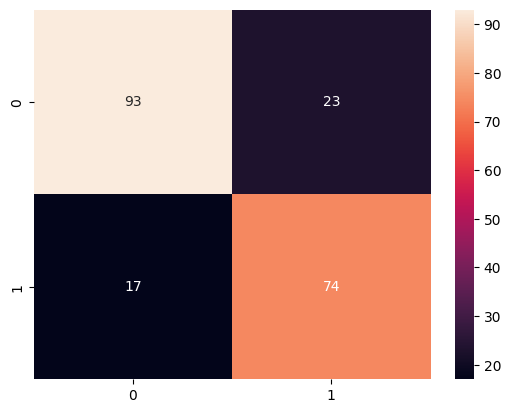

In [13]:
# Matriz de Confusão
sns.heatmap(metrics.confusion_matrix(y_test, predictions_us), annot=True)

In [14]:
# Mudar o hiperparâmetro "k" para checar o modelo com maior acurácia
scores = []
for k in range(3, 20):
    knn = KNearestNeighbours(k_neighbours=k)
    knn.fit(X_train, y_train)

    predictions = np.asarray(knn.predict(X_test))
    acc = metrics.f1_score(y_test, predictions)
    scores.append(acc)
    printer = acc * 100
    print(f"k={k} => F1-Score: {printer:.2f}%")


k=3 => F1-Score: 78.72%
k=4 => F1-Score: 80.85%
k=5 => F1-Score: 80.65%
k=6 => F1-Score: 82.54%
k=7 => F1-Score: 78.26%
k=8 => F1-Score: 79.57%
k=9 => F1-Score: 79.37%
k=10 => F1-Score: 80.42%
k=11 => F1-Score: 79.37%
k=12 => F1-Score: 80.85%
k=13 => F1-Score: 79.14%
k=14 => F1-Score: 81.48%
k=15 => F1-Score: 80.65%
k=16 => F1-Score: 81.28%
k=17 => F1-Score: 78.02%
k=18 => F1-Score: 80.65%
k=19 => F1-Score: 80.00%


In [15]:
# Melhor performance possível com esse modelo  
k_max = np.argmax(scores)
k_super = range(3,50)[k_max]
print("Melhor K:", k_super)

knn = KNearestNeighbours(k_neighbours=k_super)
knn.fit(X_train, y_train)
predictions = np.asarray(knn.predict(X_test))
metrics.full_metrics(y_test, predictions)

Melhor K: 6
Taxa de Acerto: 84.06%
Taxa de Erro:  15.94%
Acurácia:  84.06%
Precisão:  84.78%
Revocação:  80.41%
F1-Score (F-Measure):  82.54%
